In [10]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
import graph_tool.all as gt

In [11]:
sns.set_context("talk")

### 1. Data Preparation

In [12]:
from scipy.io import loadmat

In [13]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/ZfishModularity/data/ZConnectome_04292021.mat"
somalocation = loadmat(data_path) 

In [14]:
somalocation['ZConnectome'].dtype

dtype([('cellID', 'O'), ('cellType', 'O'), ('origin', 'O'), ('inVol', 'O'), ('treeLength', 'O'), ('isExistRoot', 'O'), ('connectome', 'O'), ('readme', 'O')])

In [15]:
cell_loc = dict(zip(somalocation['ZConnectome']['cellID'][0][0][:,0], 
                    somalocation['ZConnectome']['origin'][0][0]))

In [16]:
modO = gt.load_graph("saved/gt-ax50-dd100-modO-sg.xml.gz")

In [17]:
potential_DO_filter = modO.new_vertex_property("bool")
potential_DO_filter.a = np.array([cid in cell_loc.keys() and cell_loc[cid][0] > 334 
                                  for cid in modO.vp['cellid']])
potential_DO_mask = np.array(potential_DO_filter.a, dtype='bool')

### 2. Connnection Probability to Other Parts (Normalized)

In [10]:
g = gt.load_graph("saved/whole-label-ax50-dd100.xml.gz")

In [11]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_3sbm"].a))
cellid2DOsbm = dict(zip(modO.vp["cellid"].a, potential_DO_filter.a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        if cellid2modOsbm[g.vp["cellid"][v]] == 0:
            vw[v] = cellid2DOsbm[g.vp["cellid"][v]]
        else:
            vw[v] = -1
    else:
            vw[v] = -1
g.vp["modO_sg_modO1_DO"] = vw

In [12]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_3sbm"].a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["modO_sg_3sbm"] = vw

In [13]:
gen_mask = lambda x: np.array(x, dtype="bool")

In [130]:
def validate_syn_prob_inner_MI(g, sbm_name, weight='#synapses', norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask(m.vp['celltype'].a == 15)]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask(m.vp['celltype'].a == 14)]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)
            
     # merge blockO2 neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['modO_sg_3sbm'].a == 1)]
    mclass = m.get_vertices()[gen_mask(m.vp['celltype'].a == 13)]
    o2_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != o2_fv:
            merge_g.merge_vertices(v, o2_fv)

    # merge scc-0 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 0)]
    center_fv0 = mclass[0]
    # print("center-0", center_fv0)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv0:
            merge_g.merge_vertices(v, center_fv0)

    # merge scc-1 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 1)]
    center_fv1 = mclass[0]
    # print("center-1", center_fv1)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv1:
            merge_g.merge_vertices(v, center_fv1)

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()
    
    # 1st dim - receiver, 2nd dim - sender
    syn_prob_abd = A_mg[[abdm_fv,abdm_fv,abdi_fv,abdi_fv,o2_fv,o2_fv],
                        [center_fv0,center_fv1,center_fv0,center_fv1,center_fv0,center_fv1]].reshape(3,2)
    
    syn_prob_block = A_mg[[center_fv0,center_fv0,center_fv1,center_fv1],
                        [center_fv0,center_fv1,center_fv0,center_fv1]
                         ].reshape(2,2)

    return syn_prob_abd, syn_prob_block

In [132]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_inner_MI(g, "modO_{}_modO1_DO".format(k),  weight='#synapses', norm=True)

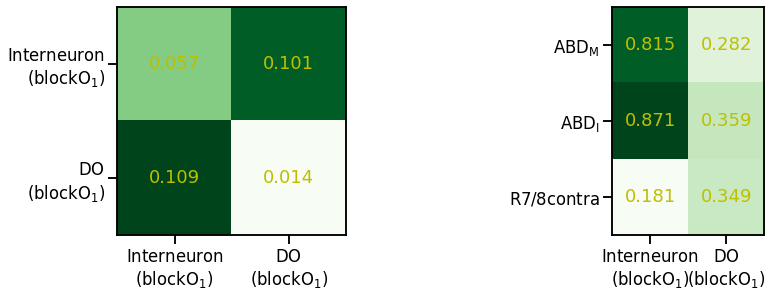

In [134]:
fig, axs = plt.subplots(1,2, figsize=(15,4.2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(3):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        ax.set_yticks(range(3))
#         ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_2$"])
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$R7/8contra$"])

plt.show()

In [17]:
def validate_syn_prob_input_inner_multi(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

#     # merge sink neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 1)]
#     fv = mclass[0]
#     # print("source", fv)
#     for i, v in enumerate(m.vertices()):
#         if v in mclass and v != fv:
#             merge_g.merge_vertices(v, fv)

    # merge blockO3 neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['modO_sg_3sbm'].a == 2))]
    O3_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O3_fv:
            merge_g.merge_vertices(v, O3_fv)

    # merge souce saccadic M neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 0))]
    sacm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != sacm_fv:
            merge_g.merge_vertices(v, sacm_fv)
        
    # merge souce saccadic I neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 1))]
    saci_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != saci_fv:
            merge_g.merge_vertices(v, saci_fv)
            
    # merge souce IBN neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 3))]
    ibn_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != ibn_fv:
            merge_g.merge_vertices(v, ibn_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat(center_fvs, 4),
                        np.tile([O3_fv,sacm_fv, saci_fv, ibn_fv], len(bids))].reshape(len(bids), 4)
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [18]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_inner_multi(g, "modO_{}_modO1_DO".format(k),  weight='#synapses', norm=True)

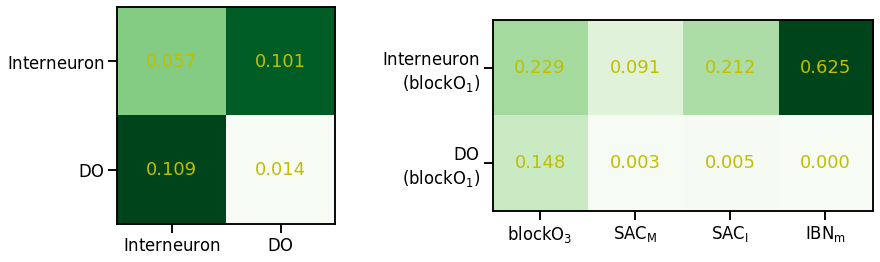

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$", "$DO$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$", "$DO$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(4):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["$blockO_3$","$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])

plt.show()

### 3. Connection to Other Parts (Summed Synapse Number)

In [101]:
def validate_syn_prob_MI(g, sbm_name, weight='#synapses', norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask( (m.vp['celltype'].a == 13))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)

    # merge scc-0 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 0)]
    center_fv0 = mclass[0]
    # print("center-0", center_fv0)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv0:
            merge_g.merge_vertices(v, center_fv0)

    # merge scc-1 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 1)]
    center_fv1 = mclass[0]
    # print("center-1", center_fv1)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv1:
            merge_g.merge_vertices(v, center_fv1)
            
    # merge scc-2 neurons
    mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == 2)]
    center_fv2 = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != center_fv2:
            merge_g.merge_vertices(v, center_fv2)

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[[abdm_fv,abdm_fv,abdm_fv,abdi_fv,abdi_fv,abdi_fv],
                        [center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2]].reshape(2,3)
    
    syn_prob_block = A_mg[[center_fv0,center_fv0,center_fv0,center_fv1,center_fv1,center_fv1,center_fv2,center_fv2,center_fv2],
                        [center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2,center_fv0,center_fv1,center_fv2]
                         ].reshape(3,3)

    return syn_prob_abd, syn_prob_block

In [102]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_{}_3sbm".format(k),  weight='#synapses', norm=False)

In [129]:
np.unique(g.vp['peripheral'].a, return_counts=True)

(PropertyArray([-1,  0,  1], dtype=int32), array([ 602, 1741,  477]))

In [122]:
np.unique(g.vp['sbm_sg'].a, return_counts=True)

(PropertyArray([-1,  0,  1], dtype=int32), array([2401,  223,  196]))

In [144]:
np.unique(g.vp['modO_sg_modO1_DO'].a, return_counts=True)

(PropertyArray([-1,  0,  1], dtype=int32), array([2740,   56,   24]))

In [128]:
((g.vp['sbm_sg'].a == -1) & (g.vp['celltype'].a == 13)).sum()

PropertyArray(31)

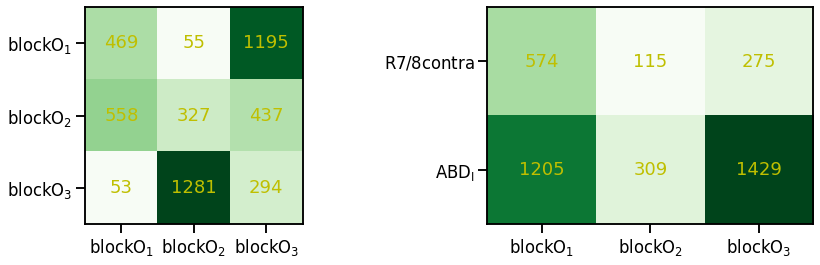

In [103]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$R7/8contra$", "$ABD_I$"])

plt.show()

In [110]:
def validate_syn_prob_input_multi(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

#     # merge sink neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 1)]
#     fv = mclass[0]
#     # print("source", fv)
#     for i, v in enumerate(m.vertices()):
#         if v in mclass and v != fv:
#             merge_g.merge_vertices(v, fv)

    # merge souce saccadic M neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 0))]
    sacm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != sacm_fv:
            merge_g.merge_vertices(v, sacm_fv)
        
    # merge souce saccadic I neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 1))]
    saci_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != saci_fv:
            merge_g.merge_vertices(v, saci_fv)
            
    # merge souce IBN neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 3))]
    ibn_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != ibn_fv:
            merge_g.merge_vertices(v, ibn_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat(center_fvs, 3),
                        np.tile([sacm_fv, saci_fv, ibn_fv], len(bids))].reshape(len(bids), 3)
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [111]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_3sbm".format(k),  weight='#synapses', bids=[0,1,2], norm=False)

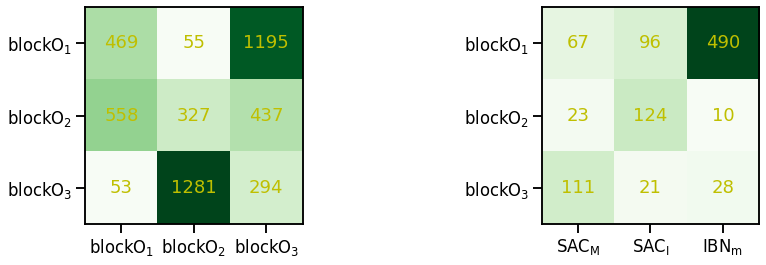

In [112]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [136]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_inner_MI(g, "modO_{}_modO1_DO".format(k),  weight='#synapses', norm=False)

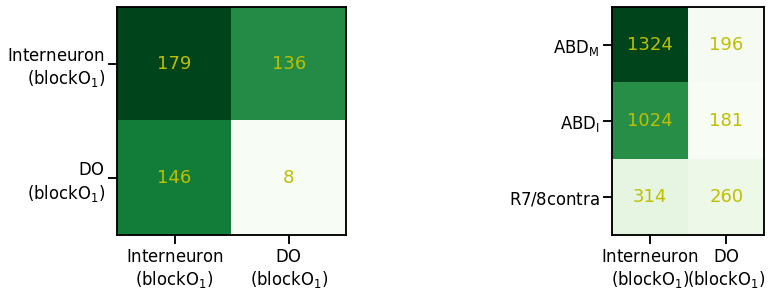

In [137]:
fig, axs = plt.subplots(1,2, figsize=(15,4.2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(3):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        ax.set_yticks(range(3))
#         ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_2$"])
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$R7/8contra$"])

plt.show()

In [28]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_inner_multi(g, "modO_{}_modO1_DO".format(k),  weight='#synapses', norm=False)

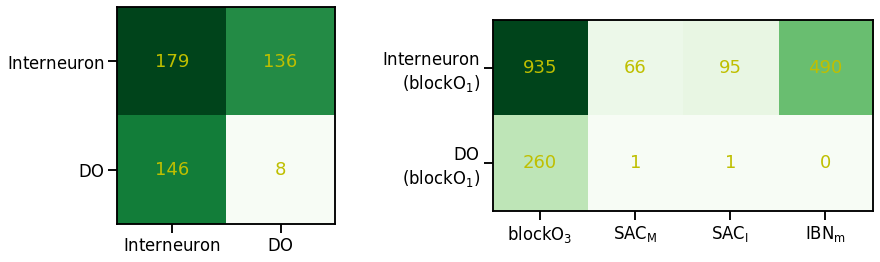

In [29]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$", "$DO$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$", "$DO$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["$blockO_3$","$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])

plt.show()

### 4. Connection to Other Parts (Summed Connections)

In [30]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_{}_3sbm".format(k),  weight=None, norm=False)

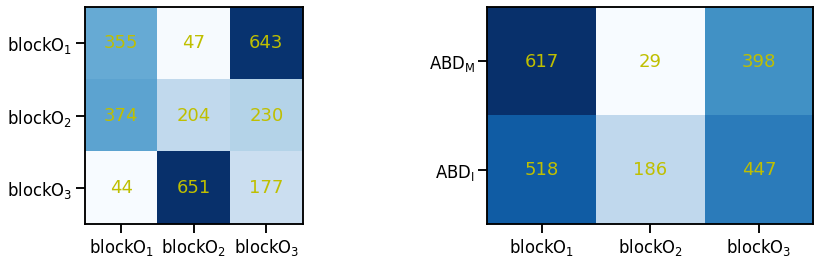

In [31]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [32]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_3sbm".format(k),  weight=None, bids=[0,1,2], norm=False)

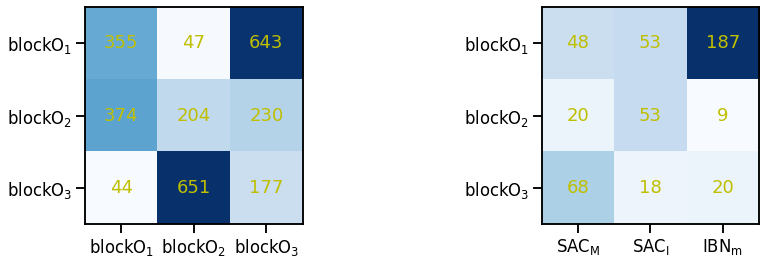

In [33]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [34]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_inner_MI(g, "modO_{}_modO1_DO".format(k),  weight=None, norm=False)

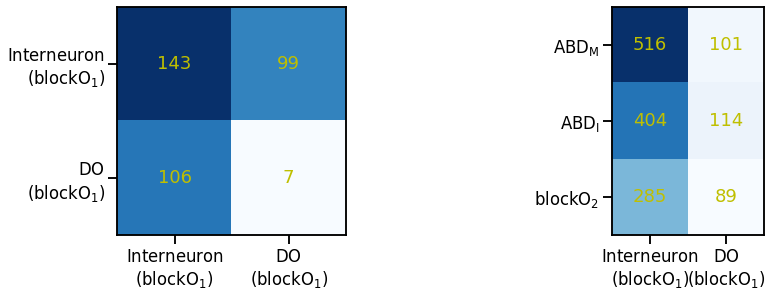

In [35]:
fig, axs = plt.subplots(1,2, figsize=(15,4.2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(3):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_2$"])

plt.show()

In [36]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_inner_multi(g, "modO_{}_modO1_DO".format(k),  weight=None, norm=False)

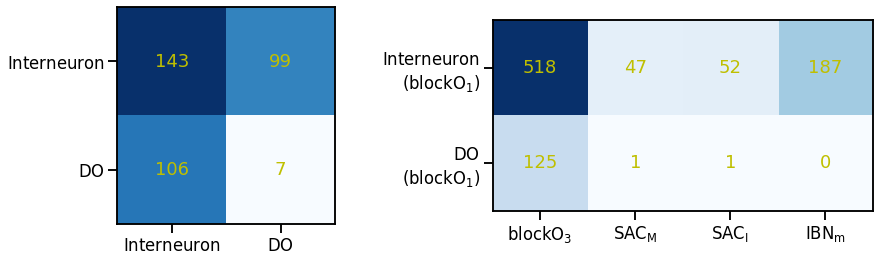

In [37]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["$Interneuron$", "$DO$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$", "$DO$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(2):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["$blockO_3$","$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$Interneuron$\n$(blockO_1)$", "$DO$\n$(blockO_1)$"])

plt.show()

### 5. Participation in 3-cycles

In [38]:
# count number of 3-cycle in (1,2,3)
group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2]]

def count_unicycles(group_partition):
    allcycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in modO.edges():
            if (modO.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
               (modO.vp["modO_sg_3sbm"][e1.target()] == grp[1]) and\
               (not e1.source() in modO.get_out_neighbors(e1.target())):

                for e2 in modO.get_out_edges(e1.target()):
                    if (modO.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                       (modO.vp["modO_sg_3sbm"][e2[1]] == grp[2]) and\
                       (not e2[0] in modO.get_out_neighbors(e2[1])):

                        for e3 in modO.get_out_edges(e2[1]):
                            if (modO.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]) and\
                               (not e3[0] in modO.get_out_neighbors(e3[1])):

                                allcycle_cnt[str(grp)] += 1
        # given unicycles.. 
        # only cycles with all nodes in the same module can be counted multiple times (x3).
        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        allcycle_cnt[str(grp)] = allcycle_cnt[str(grp)] / dup_fac
        
    return allcycle_cnt

modO3unicycle_cnt = count_unicycles(group_partition)

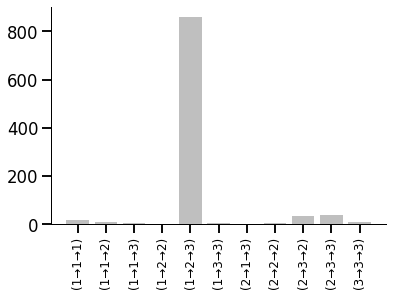

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.bar(range(11), height=list(modO3unicycle_cnt.values()), color='gray', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

In [40]:
np.sum(list(modO3unicycle_cnt.values()))

985.0

In [41]:
def uni_rec_prob(group_partition):
    allcycle_cnt = {str(grp): 0 for grp in group_partition}
    all2egdes_cnt = {str(grp): 0 for grp in group_partition}
    rec_prob = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in modO.edges():
            if (modO.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
               (modO.vp["modO_sg_3sbm"][e1.target()] == grp[1]) and\
               (not e1.source() in modO.get_out_neighbors(e1.target())):

                for e2 in modO.get_out_edges(e1.target()):
                    if (modO.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                       (modO.vp["modO_sg_3sbm"][e2[1]] == grp[2]) and\
                       (not e2[0] in modO.get_out_neighbors(e2[1])):
                        
                        all2egdes_cnt[str(grp)] += 1

                        for e3 in modO.get_out_edges(e2[1]):
                            if (modO.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]) and\
                               (not e3[0] in modO.get_out_neighbors(e3[1])):

                                allcycle_cnt[str(grp)] += 1
            
        print(grp, allcycle_cnt[str(grp)], all2egdes_cnt[str(grp)])
        rec_prob[str(grp)] = allcycle_cnt[str(grp)] / all2egdes_cnt[str(grp)]
        
    return rec_prob

uni_rec_prob([[0,1,2],[1,2,0],[2,0,1]])

[0, 1, 2] 859 3381
[1, 2, 0] 859 5395
[2, 0, 1] 859 3351


{'[0, 1, 2]': 0.2540668441289559,
 '[1, 2, 0]': 0.1592215013901761,
 '[2, 0, 1]': 0.25634139062966277}

In [42]:
def count_cycles(group_partition):
    allbicycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in modO.edges():
            if (modO.vp["modO_sg_3sbm"][e1.source()] == grp[0]) and\
               (modO.vp["modO_sg_3sbm"][e1.target()] == grp[1]):

                for e2 in modO.get_out_edges(e1.target()):
                    if (modO.vp["modO_sg_3sbm"][e2[0]] == grp[1]) and\
                       (modO.vp["modO_sg_3sbm"][e2[1]] == grp[2]):

                        for e3 in modO.get_out_edges(e2[1]):
                            if (modO.vp["modO_sg_3sbm"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]):

                                allbicycle_cnt[str(grp)] += 1
        # given unicycles.. 
        # only cycles with all nodes in the same module can be counted multiple times (x3).
        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        allbicycle_cnt[str(grp)] = allbicycle_cnt[str(grp)] / dup_fac

    return allbicycle_cnt

modO3cycle_cnt = count_cycles(group_partition)

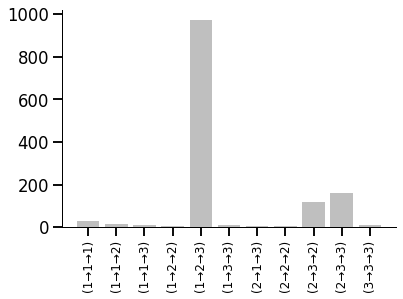

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.bar(range(11), height=list(modO3cycle_cnt.values()), color='gray', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

In [44]:
potential_DO_filter = modO.new_vertex_property("bool")
potential_DO_filter.a = np.array([cid in cell_loc.keys() and cell_loc[cid][0] > 334
                                  for cid in modO.vp['cellid']])
potential_DO_mask = np.array(potential_DO_filter.a, dtype='bool')

In [45]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_3sbm"].a))
cellid2DOsbm = dict(zip(modO.vp["cellid"].a, potential_DO_filter.a))

vw = modO.new_vertex_property("int32_t")
for i, v in enumerate(modO.vertices()):

    blk = cellid2modOsbm[modO.vp["cellid"][v]]
    if cellid2modOsbm[modO.vp["cellid"][v]] == 0:
        is_DO = cellid2DOsbm[modO.vp["cellid"][v]]
        vw[v] = 0-is_DO
    else:
        vw[v] = blk

modO.vp["blockO1_DO"] = vw

In [46]:
np.sum(modO.vp["blockO1_DO"].a==0)

PropertyArray(56)

In [47]:
# count number of 3-cycle in (DO/IN,2,3)
DO_group_partition = [[-1,1,2],[0,1,2]]

def count_unicycles_DO(group_partition):
    allcycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in modO.edges():
            if (modO.vp["blockO1_DO"][e1.source()] == grp[0]) and\
               (modO.vp["blockO1_DO"][e1.target()] == grp[1]) and\
               (not e1.source() in modO.get_out_neighbors(e1.target())):

                for e2 in modO.get_out_edges(e1.target()):
                    if (modO.vp["blockO1_DO"][e2[0]] == grp[1]) and\
                       (modO.vp["blockO1_DO"][e2[1]] == grp[2]) and\
                       (not e2[0] in modO.get_out_neighbors(e2[1])):

                        for e3 in modO.get_out_edges(e2[1]):
                            if (modO.vp["blockO1_DO"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]) and\
                               (not e3[0] in modO.get_out_neighbors(e3[1])):

                                allcycle_cnt[str(grp)] += 1
        # given unicycles.. 
        # only cycles with all nodes in the same module can be counted multiple times (x3).
        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        allcycle_cnt[str(grp)] = allcycle_cnt[str(grp)] / dup_fac
        
    return allcycle_cnt

modO3unicycle_cnt_DO = count_unicycles_DO(DO_group_partition)

In [48]:
modO3unicycle_cnt_DO

{'[-1, 1, 2]': 57.0, '[0, 1, 2]': 802.0}

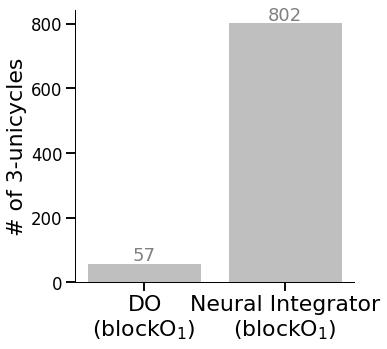

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.bar(range(2), height=list(modO3unicycle_cnt_DO.values()), color='gray', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(2))
ax.annotate("57", (-0.08,66), color='gray')
ax.annotate("802", (1-0.12,810), color='gray')
ax.set_xticklabels(["$DO$\n$(blockO_1)$","Neural Integrator\n$(blockO_1)$"], fontsize=22)
ax.set_ylabel("# of 3-unicycles", fontsize=22)
plt.savefig("figures/paper/DO-cycles.pdf", bbox_inches="tight")

### 6. Remove DO neurons

In [26]:
modO_IN = modO.copy()

potential_DO_filter_IN = modO_IN.new_vertex_property("bool")
potential_DO_filter_IN.a = ~np.array([cid in cell_loc.keys() and cell_loc[cid][0] > 334
                                  for cid in modO_IN.vp['cellid']])

modO_IN.set_vertex_filter(potential_DO_filter_IN)

In [27]:
modO_IN = gt.Graph(modO_IN, prune=True)
modO_IN

<Graph object, directed, with 197 vertices and 2240 edges, 22 internal vertex properties, 2 internal edge properties, at 0x7fe24e004320>

In [28]:
from utils.measure import *

In [29]:
%%time
verbose = False
SBMs_modO_IN_sg_anneal = [gt.minimize_blockmodel_dl(modO_IN, deg_corr=True, 
                                B_min=3, B_max=3,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(10)]

CPU times: user 1min 25s, sys: 236 ms, total: 1min 25s
Wall time: 1min 14s


In [30]:
blocks = [SBM.get_blocks().a for SBM in SBMs_modO_IN_sg_anneal] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.9709773587946176

In [31]:
sbm_modO_IN_sg = SBMs_modO_IN_sg_anneal[np.argmin([SBM.entropy() for SBM in SBMs_modO_IN_sg_anneal])] 

In [32]:
sbm_modO_IN_sg

<BlockState object with 3 blocks (3 nonempty), degree-corrected, for graph <Graph object, directed, with 197 vertices and 2240 edges, 22 internal vertex properties, 2 internal edge properties, at 0x7fe24e004320>, at 0x7fe2290c2b70>

In [33]:
vw = modO_IN.new_vertex_property("int32_t")
for i, v in enumerate(modO_IN.vertices()):
    vw[v] = sbm_modO_IN_sg.get_blocks().a[i]
modO_IN.vp["modO_sg_3sbm_nonDO"] = vw

In [34]:
cellid2modOsbm = dict(zip(modO_IN.vp["cellid"].a, modO_IN.vp["modO_sg_3sbm_nonDO"].a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["modO_IN_sg_3sbm_nonDO"] = vw

In [35]:
cellid2modOdo = dict(zip(modO.vp["cellid"].a, potential_DO_filter.a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOdo.keys():
        if cellid2modOdo[g.vp["cellid"][v]]:
            vw[v] = 1
        else:
            vw[v] = 0
    else:
        vw[v] = 0
g.vp["DO"] = vw

In [36]:
np.sum(g.vp["modO_IN_sg_3sbm_nonDO"].a == 0), np.sum(g.vp["modO_IN_sg_3sbm_nonDO"].a == 1), np.sum(g.vp["modO_IN_sg_3sbm_nonDO"].a == 2)

(PropertyArray(48), PropertyArray(83), PropertyArray(66))

In [373]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_IN_{}_3sbm_nonDO".format(k),  weight='#synapses', norm=True)

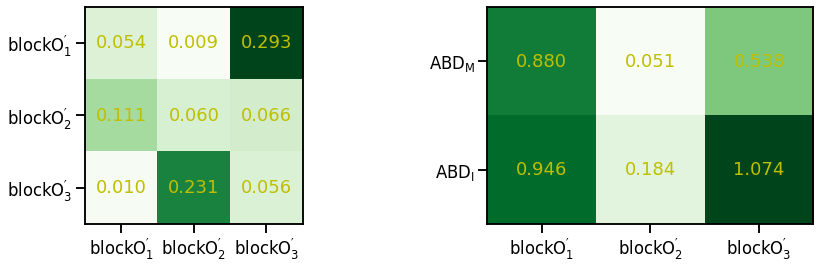

In [374]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [375]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_IN_{}_3sbm_nonDO".format(k),  weight='#synapses', bids=[0,1,2], norm=True)

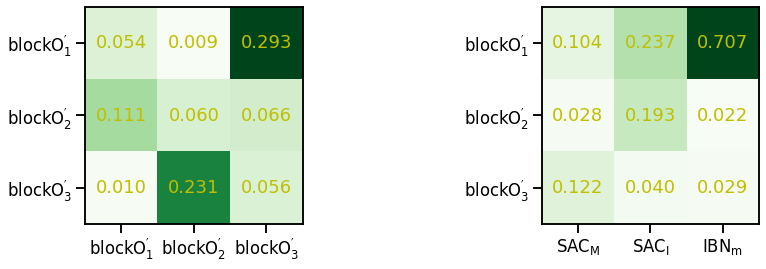

In [376]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])

plt.show()

In [37]:
# count number of 3-cycle in (1,2,3)
group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2]]

def count_unicycles_nonDO(group_partition):
    allcycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in modO_IN.edges():
            if (modO_IN.vp["modO_sg_3sbm_nonDO"][e1.source()] == grp[0]) and\
               (modO_IN.vp["modO_sg_3sbm_nonDO"][e1.target()] == grp[1]) and\
               (not e1.source() in modO_IN.get_out_neighbors(e1.target())):

                for e2 in modO_IN.get_out_edges(e1.target()):
                    if (modO_IN.vp["modO_sg_3sbm_nonDO"][e2[0]] == grp[1]) and\
                       (modO_IN.vp["modO_sg_3sbm_nonDO"][e2[1]] == grp[2]) and\
                       (not e2[0] in modO_IN.get_out_neighbors(e2[1])):

                        for e3 in modO_IN.get_out_edges(e2[1]):
                            if (modO_IN.vp["modO_sg_3sbm_nonDO"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]) and\
                               (not e3[0] in modO_IN.get_out_neighbors(e3[1])):

                                allcycle_cnt[str(grp)] += 1
        # given unicycles.. 
        # only cycles with all nodes in the same module can be counted multiple times (x3).
        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        allcycle_cnt[str(grp)] = allcycle_cnt[str(grp)] / dup_fac
        
    return allcycle_cnt

modO_IN3unicycle_cnt = count_unicycles_nonDO(group_partition)

In [38]:
modO_IN3unicycle_cnt

{'[0, 0, 0]': 5.0,
 '[0, 0, 1]': 1.0,
 '[0, 0, 2]': 5.0,
 '[0, 1, 1]': 1.0,
 '[0, 1, 2]': 806.0,
 '[0, 2, 2]': 1.0,
 '[1, 0, 2]': 1.0,
 '[1, 1, 1]': 2.0,
 '[1, 2, 1]': 35.0,
 '[1, 2, 2]': 37.0,
 '[2, 2, 2]': 6.0}

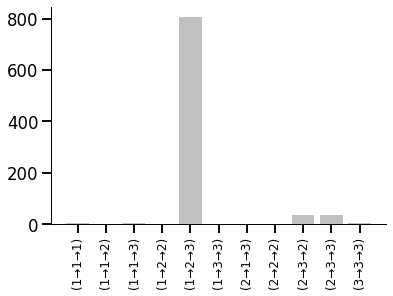

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.bar(range(11), height=list(modO_IN3unicycle_cnt.values()), color='gray', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

In [42]:
def validate_syn_prob_MI_single_do(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['celltype'].a == 14))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)
            
    # merge blockO1 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_IN_sg_3sbm_nonDO'].a == 0))]
    O1_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O1_fv:
            merge_g.merge_vertices(v, O1_fv)
            
    # merge blockO2 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_IN_sg_3sbm_nonDO'].a == 1))]
    O2_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O2_fv:
            merge_g.merge_vertices(v, O2_fv)
            
    # merge blockO3 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_IN_sg_3sbm_nonDO'].a == 2))]
    O3_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O3_fv:
            merge_g.merge_vertices(v, O3_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat([abdm_fv,abdi_fv,O1_fv,O2_fv,O3_fv], len(bids)),
                        np.tile(center_fvs, 5)].reshape(5, len(bids))
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [43]:
def validate_syn_prob_input_single_do(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

#     # merge sink neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 1)]
#     fv = mclass[0]
#     # print("source", fv)
#     for i, v in enumerate(m.vertices()):
#         if v in mclass and v != fv:
#             merge_g.merge_vertices(v, fv)

    # merge souce saccadic M neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 0))]
    sacm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != sacm_fv:
            merge_g.merge_vertices(v, sacm_fv)
        
    # merge souce saccadic I neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 1))]
    saci_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != saci_fv:
            merge_g.merge_vertices(v, saci_fv)
            
    # merge souce IBN neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 2))]
    ibn_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != ibn_fv:
            merge_g.merge_vertices(v, ibn_fv)
            
    # merge blockO1 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_IN_sg_3sbm_nonDO'].a == 0))]
    O1_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O1_fv:
            merge_g.merge_vertices(v, O1_fv)
            
    # merge blockO2 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_IN_sg_3sbm_nonDO'].a == 1))]
    O2_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O2_fv:
            merge_g.merge_vertices(v, O2_fv)
            
    # merge blockO3 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_IN_sg_3sbm_nonDO'].a == 2))]
    O3_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O3_fv:
            merge_g.merge_vertices(v, O3_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat(center_fvs, 6),
                        np.tile([sacm_fv, saci_fv, ibn_fv, 
                                 O1_fv, O2_fv, O3_fv], len(bids))].reshape(len(bids), 6)
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [412]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_single_do(g, "DO".format(k), bids=[1], weight='#synapses', norm=True)

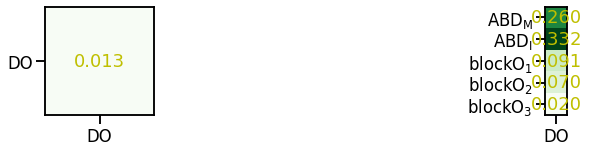

In [417]:
fig, axs = plt.subplots(1,2, figsize=(15,2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(1):
            for j in range(1):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(1))
        ax.set_xticklabels(["DO"])
        ax.set_yticks(range(1))
        ax.set_yticklabels(["DO"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(5):
            for j in range(1):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(1))
        ax.set_xticklabels(["DO"])
        ax.set_yticks(range(5))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [409]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_single_do(g, "DO".format(k), bids=[1], weight='#synapses', norm=True)

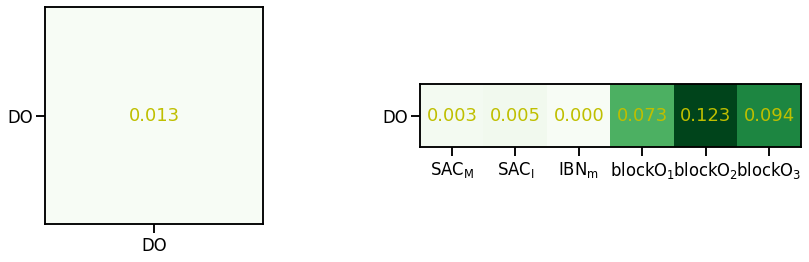

In [411]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(1):
            for j in range(1):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(1))
        ax.set_xticklabels(["DO"])
        ax.set_yticks(range(1))
        ax.set_yticklabels(["DO"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(1):
            for j in range(6):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(6))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(1))
        ax.set_yticklabels(["DO"])

plt.show()

In [427]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI(g, "modO_IN_{}_3sbm_nonDO".format(k),  weight=None, norm=False)

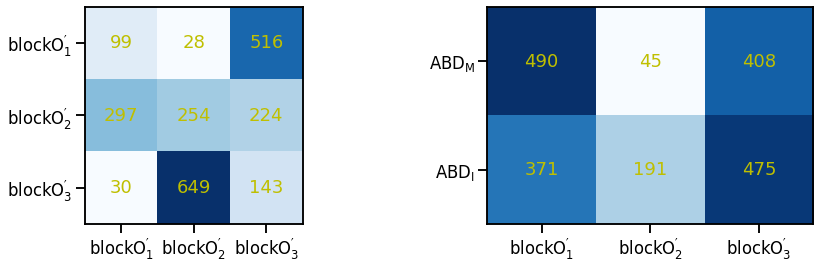

In [428]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(2):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [429]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_IN_{}_3sbm_nonDO".format(k),  weight=None, bids=[0,1,2], norm=False)

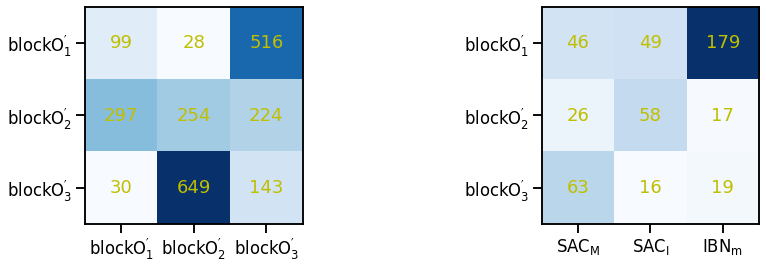

In [430]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(3):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(3))
        ax.set_yticklabels(["$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])

plt.show()

In [432]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_single_do(g, "DO".format(k), bids=[1], weight=None, norm=False)

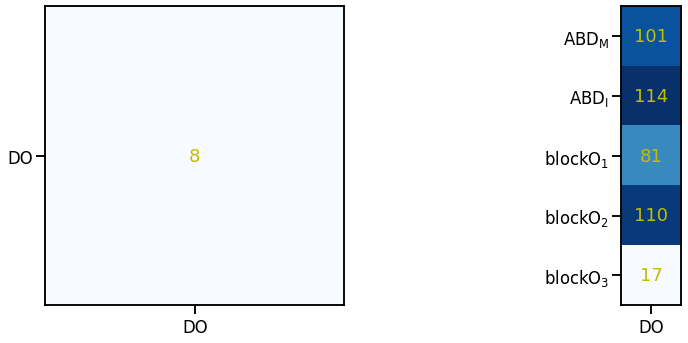

In [433]:
fig, axs = plt.subplots(1,2, figsize=(15,5.5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(1):
            for j in range(1):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(1))
        ax.set_xticklabels(["DO"])
        ax.set_yticks(range(1))
        ax.set_yticklabels(["DO"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(5):
            for j in range(1):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(1))
        ax.set_xticklabels(["DO"])
        ax.set_yticks(range(5))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [434]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_single_do(g, "DO".format(k), bids=[1], weight=None, norm=False)

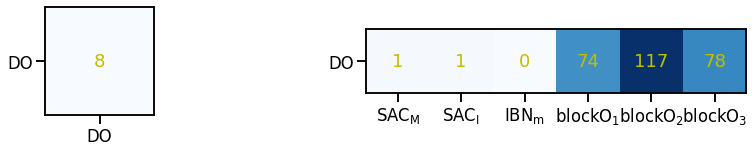

In [436]:
fig, axs = plt.subplots(1,2, figsize=(15,2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(1):
            for j in range(1):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(1))
        ax.set_xticklabels(["DO"])
        ax.set_yticks(range(1))
        ax.set_yticklabels(["DO"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(1):
            for j in range(6):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(6))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(1))
        ax.set_yticklabels(["DO"])

plt.show()

### 6. What about a 4-block structure of modO?

In [221]:
%%time
verbose = False
SBMs_sg_anneal_4b = [gt.minimize_blockmodel_dl(modO, deg_corr=True, 
                                B_min=4, B_max=4,
                                mcmc_multilevel_args=dict(anneal=True, verbose=verbose),
                                verbose=verbose) for _ in range(20)]

CPU times: user 2min 53s, sys: 288 ms, total: 2min 53s
Wall time: 2min 32s


In [222]:
blocks = [SBM.get_blocks().a for SBM in SBMs_sg_anneal_4b] 
rscore = []
for i in range(10):
    for j in range(i+1, 10):
        rscore.append(rand_index_score(blocks[i], blocks[j]))
np.mean(rscore)

0.9085578852394997

In [242]:
def validate_syn_prob_MI_multi(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge source neurons
    mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 0)]
    fv = mclass[0]
    # print("source", fv)
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != fv:
            merge_g.merge_vertices(v, fv)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['peripheral'].a == 1) & 
                                       (m.vp['celltype'].a == 14))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat([abdm_fv,abdi_fv], len(bids)),
                        np.tile(center_fvs, 2)].reshape(2, len(bids))
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [223]:
sbm_sg_4b = SBMs_sg_anneal_4b[np.argmin([SBM.entropy() for SBM in SBMs_sg_anneal_4b])]

In [268]:
sum(sbm_sg_4b.get_blocks().a==3)

64

In [437]:
sbm_sg_4b.entropy()

9132.003448655028

In [225]:
show_index = [4,5,8,9,10,11,12]
typenames = ['Saccadic_M', 'Saccadic_I', 'IBN', 'IBNmirrorPop', 'RS', 'Vestibular_DO', 'Vestibular_MO', 'Vestibular_TO', 'Integrator_r456I', 'Integrator_r456M', 'Integrator_r456MI', 'Integrator_r56M', 'Integrator_r78ipis', 'Integrator_r78contra', 'Abducens_M', 'Abducens_I']
type_filter = np.array(modO.vp["celltype"].a != -1)

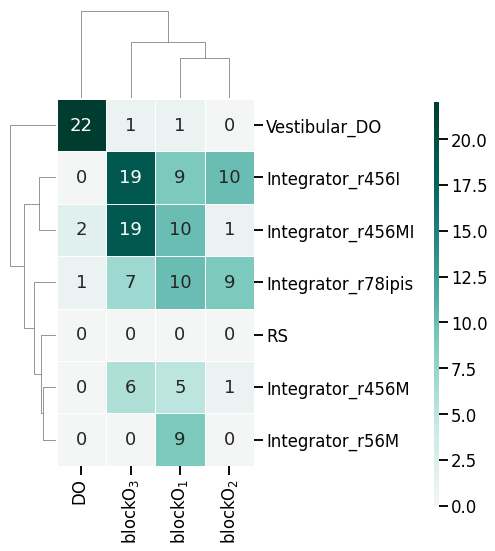

In [230]:
dic_SBM2Type = np.array([np.array(sbm_sg_4b.get_blocks().a)[type_filter].tolist(), 
                         np.array(modO.vp["celltype"].a)[type_filter].tolist()]).T
typeM = np.zeros((4, 16))
for i in range(4):
#     print("---")
#     print("SBM type: {}".format(i))
    ids, cnts = np.unique(dic_SBM2Type[dic_SBM2Type[:,0]==i][:,1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        typeM[i, nid] = cnt
#         print(str(cnt)+" x "+str(name))

type_grid = sns.clustermap(typeM.T[show_index], 
               center=0, 
            xticklabels=["$blockO_1$", "$blockO_2$", "$DO$", "$blockO_3$"],
            yticklabels=np.array(typenames)[show_index],
            figsize=(6.2,8),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
plt.show()

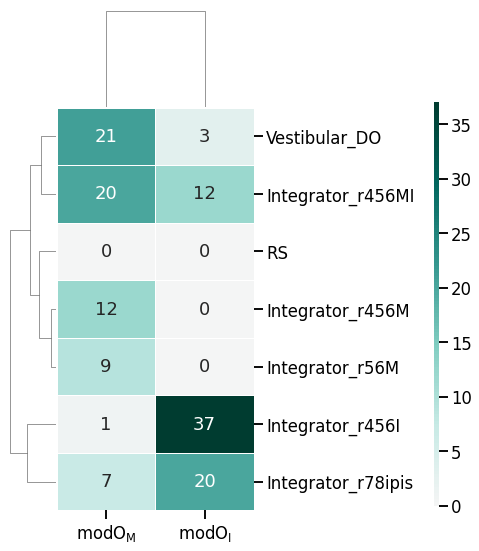

In [360]:
dic_SBM2Type = np.array([np.array(modO.vp["modO_sg_sbm"].a)[type_filter].tolist(), 
                         np.array(modO.vp["celltype"].a)[type_filter].tolist()]).T
typeM = np.zeros((2, 16))
for i in range(2):
#     print("---")
#     print("SBM type: {}".format(i))
    ids, cnts = np.unique(dic_SBM2Type[dic_SBM2Type[:,0]==i][:,1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        typeM[i, nid] = cnt
#         print(str(cnt)+" x "+str(name))

type_grid = sns.clustermap(typeM.T[show_index], 
               center=0, 
            xticklabels=["$modO_M$", "$modO_I$"],
            yticklabels=np.array(typenames)[show_index],
            figsize=(6.2,8),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
plt.show()

In [234]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, sbm_sg_4b.get_blocks().a))

vw = modO.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if modO.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[modO.vp["cellid"][v]]
    else:
        vw[v] = -1
modO.vp["modO_sg_4sbm"] = vw

In [235]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_4sbm"].a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
        vw[v] = -1
g.vp["modO_sg_4sbm"] = vw

In [243]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "modO_{}_4sbm".format(k),  weight='#synapses', bids=[2,0,1,3], norm=True)

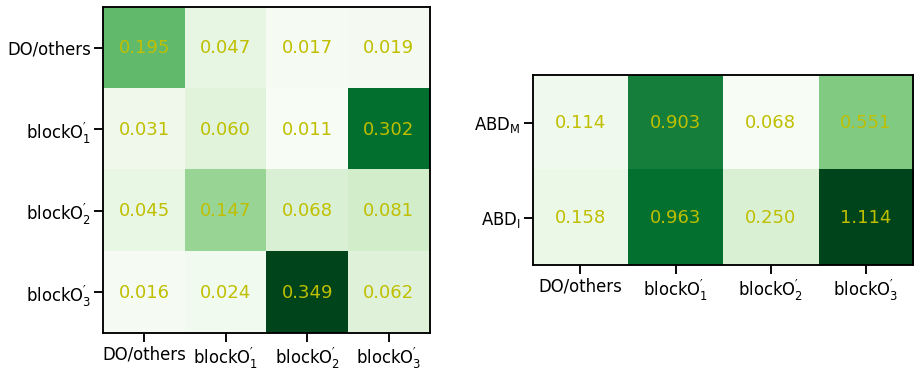

In [244]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(4):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [236]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_4sbm".format(k),  weight='#synapses', bids=[2,0,1,3], norm=True)

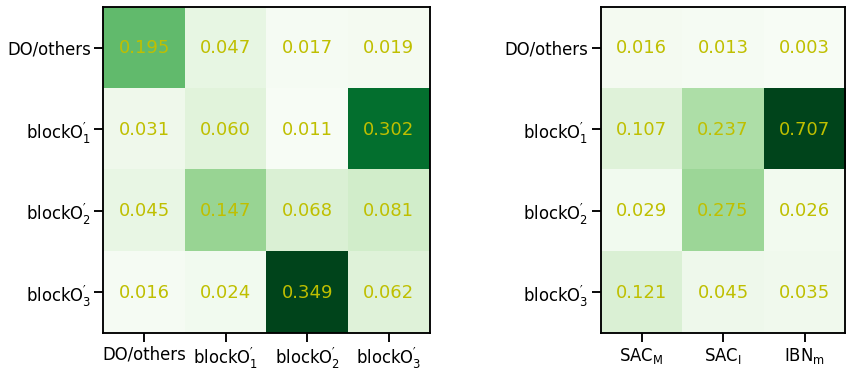

In [241]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(4):
            for j in range(3):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1'$", "$blockO_2'$", "$blockO_3'$"])

plt.show()

In [45]:
# count number of 3-cycle in (1,2,3)
group_partition = [[0,0,0],[0,0,1],[0,0,2],
                   [0,1,1],[0,1,2],[0,2,2],
                   [1,0,2],[1,1,1],[1,2,1],
                   [1,2,2],[2,2,2],
                   
                   [3,3,3],[3,3,1],[3,3,2],
                   [3,1,1],[3,1,2],[3,2,2],
                   [1,3,2],
                   
                   [0,0,3],
                   [0,3,3],[0,3,2],
                   [3,0,2],
                   
                   [0,1,3],
                   [1,0,3],[1,3,1],
                   [1,3,3]]

def count_unicycles_4sbm(group_partition):
    allcycle_cnt = {str(grp): 0 for grp in group_partition}

    for grp in group_partition:

        for e1 in modO.edges():
            if (modO.vp["modO_sg_4sbm"][e1.source()] == grp[0]) and\
               (modO.vp["modO_sg_4sbm"][e1.target()] == grp[1]) and\
               (not e1.source() in modO.get_out_neighbors(e1.target())):

                for e2 in modO.get_out_edges(e1.target()):
                    if (modO.vp["modO_sg_4sbm"][e2[0]] == grp[1]) and\
                       (modO.vp["modO_sg_4sbm"][e2[1]] == grp[2]) and\
                       (not e2[0] in modO.get_out_neighbors(e2[1])):

                        for e3 in modO.get_out_edges(e2[1]):
                            if (modO.vp["modO_sg_4sbm"][e3[0]] == grp[2]) and\
                               (e1.source() == e3[1]) and\
                               (not e3[0] in modO.get_out_neighbors(e3[1])):

                                allcycle_cnt[str(grp)] += 1
        # given unicycles.. 
        # only cycles with all nodes in the same module can be counted multiple times (x3).
        dup_fac = 1 if len(np.unique(grp)) > 1 else 3
        allcycle_cnt[str(grp)] = allcycle_cnt[str(grp)] / dup_fac
        
    return allcycle_cnt

modO3unicycle_cnt_4sbm = count_unicycles_4sbm(group_partition)

In [46]:
modO3unicycle_cnt_4sbm

{'[0, 0, 0]': 4.0,
 '[0, 0, 1]': 2.0,
 '[0, 0, 2]': 9.0,
 '[0, 1, 1]': 1.0,
 '[0, 1, 2]': 10.0,
 '[0, 2, 2]': 4.0,
 '[1, 0, 2]': 1.0,
 '[1, 1, 1]': 2.0,
 '[1, 2, 1]': 0.0,
 '[1, 2, 2]': 13.0,
 '[2, 2, 2]': 52.0,
 '[3, 3, 3]': 6.0,
 '[3, 3, 1]': 35.0,
 '[3, 3, 2]': 0.0,
 '[3, 1, 1]': 28.0,
 '[3, 1, 2]': 0.0,
 '[3, 2, 2]': 6.0,
 '[1, 3, 2]': 7.0,
 '[0, 0, 3]': 5.0,
 '[0, 3, 3]': 1.0,
 '[0, 3, 2]': 0.0,
 '[3, 0, 2]': 0.0,
 '[0, 1, 3]': 798.0,
 '[1, 0, 3]': 1.0,
 '[1, 3, 1]': 28.0,
 '[1, 3, 3]': 35.0}

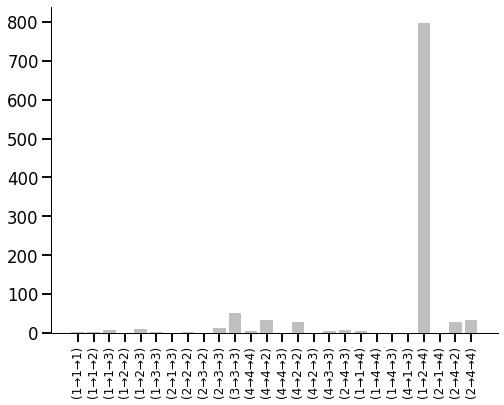

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plt.bar(range(26), height=list(modO3unicycle_cnt_4sbm.values()), color='gray', alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xticks(np.arange(26))
ax.set_xticklabels(["({}→{}→{})".format(grp[0]+1, grp[1]+1, grp[2]+1) 
                        for grp in group_partition], fontsize=12, rotation = 90)
plt.show()

### 7. What's in DO/others?

In [1]:
import navis
import matplotlib.pyplot as plt

In [2]:
skeleton_dir = lambda x: "../datasets/ZFishSkel/combinedConsensus-resampled-relabelled/{}_reRoot_reSample_5000.swc".format(x)

In [18]:
from os.path import exists
blockO1_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_4sbm'].a==0] if exists(skeleton_dir(cid))])
blockO2_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_4sbm'].a==1] if exists(skeleton_dir(cid))])
blockO3_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_4sbm'].a==3] if exists(skeleton_dir(cid))])
DOother_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_4sbm'].a==2] if exists(skeleton_dir(cid))])

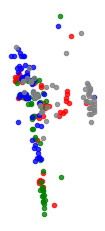

In [19]:
syn_loc = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in DOother_skel])
syn_loc2 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in blockO1_skel])
syn_loc3 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in blockO2_skel])
syn_loc4 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in blockO3_skel])

fig, ax = plt.subplots(1,1)
plt.axis('off')
ax.plot(syn_loc2[:,1], syn_loc2[:,0], '.', color='red', alpha=0.8)
ax.plot(syn_loc3[:,1], syn_loc3[:,0], '.', color='green', alpha=0.8)
ax.plot(syn_loc4[:,1], syn_loc4[:,0], '.', color='blue', alpha=0.8)
ax.plot(syn_loc[:,1], syn_loc[:,0], '.', color='gray', alpha=0.8)
ax.set_aspect('equal')
plt.show()

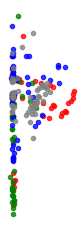

In [20]:
syn_loc = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in DOother_skel])
syn_loc2 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in blockO1_skel])
syn_loc3 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in blockO2_skel])
syn_loc4 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in blockO3_skel])

fig, ax = plt.subplots(1,1)
plt.axis('off')
ax.plot(syn_loc2[:,2], syn_loc2[:,0], '.', color='red', alpha=0.8)
ax.plot(syn_loc3[:,2], syn_loc3[:,0], '.', color='green', alpha=0.8)
ax.plot(syn_loc4[:,2], syn_loc4[:,0], '.', color='blue', alpha=0.8)
ax.plot(syn_loc[:,2], syn_loc[:,0], '.', color='gray', alpha=0.8)
ax.set_aspect('equal')
plt.show()

In [21]:
modO1_DO_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_3sbm'].a==0] 
                                  if (exists(skeleton_dir(cid)) and 
                                      (cid in cell_loc.keys() and cell_loc[cid][0] > 334))])
modO1_nonDO_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_3sbm'].a==0] 
                                  if (exists(skeleton_dir(cid)) and 
                                      (cid in cell_loc.keys() and cell_loc[cid][0] <= 334))])

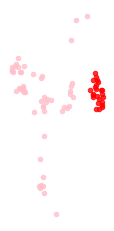

In [22]:
syn_loc = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in modO1_DO_skel])
syn_loc2 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in modO1_nonDO_skel])

fig, ax = plt.subplots(1,1)
plt.axis('off')
ax.plot(syn_loc[:,1], syn_loc[:,0], '.', color='red', alpha=0.8)
ax.plot(syn_loc2[:,1], syn_loc2[:,0], '.', color='pink', alpha=0.8)
ax.set_aspect('equal')
plt.show()

In [23]:
len(syn_loc)

24

In [48]:
labeled_DO

[76631,
 76656,
 76660,
 77255,
 77375,
 77393,
 77395,
 77807,
 78426,
 80223,
 80572,
 80591,
 80622,
 80672,
 80760,
 81126,
 81328,
 81553,
 81575,
 81582,
 81870,
 82161,
 82165,
 82169]

In [39]:
labeled_DO = list(modO.vp["cellid"].a[modO.vp['celltype'].a == 5])

In [47]:
inferred_DO = [cid for cid in modO.vp["cellid"].a[modO.vp['modO_sg_3sbm'].a==0] 
                                  if (exists(skeleton_dir(cid)) and 
                                      (cid in cell_loc.keys() and cell_loc[cid][0] > 334))]

In [41]:
[n for n in labeled_DO if n not in inferred_DO]

[81870]

In [42]:
[n for n in inferred_DO if n not in labeled_DO]

[81441]

In [44]:
[n for n in inferred_DO if n not in labeled_DO]

[77237]

In [46]:
[n for n in inferred_DO if n not in labeled_DO]

[]

In [ ]:
[navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_3sbm'].a==0] 
                                  if (exists(skeleton_dir(cid)) and 
                                      (cid in cell_loc.keys() and cell_loc[cid][0] > 334))]

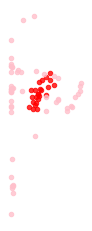

In [164]:
syn_loc = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in modO1_DO_skel])
syn_loc2 = np.array([np.array(neuron.nodes[['x', 'y', 'z']].iloc[0]) for neuron in modO1_nonDO_skel])

fig, ax = plt.subplots(1,1)
plt.axis('off')
ax.plot(syn_loc[:,2], syn_loc[:,0], '.', color='red', alpha=0.8)
ax.plot(syn_loc2[:,2], syn_loc2[:,0], '.', color='pink', alpha=0.8)
ax.set_aspect('equal')
plt.show()

In [154]:
DOother_DO_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_4sbm'].a==2] 
                                  if (exists(skeleton_dir(cid)) and 
                                      (cid in cell_loc.keys() and cell_loc[cid][0] > 334))])
DOother_nonDO_skel = navis.NeuronList([navis.read_swc(skeleton_dir(cid)) for cid in modO.vp["cellid"].a[modO.vp['modO_sg_4sbm'].a==2] 
                                  if (exists(skeleton_dir(cid)) and 
                                      ~(cid in cell_loc.keys() and cell_loc[cid][0] > 334))])

Plot neurons:   0%|          | 0/30 [00:00<?, ?it/s]

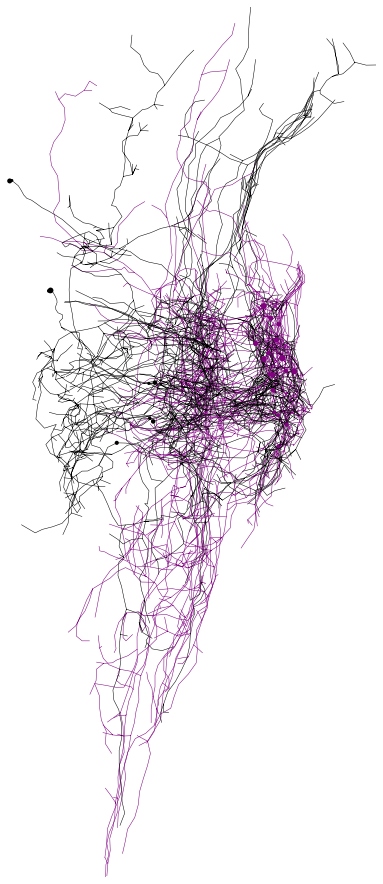

In [155]:
fig, ax = navis.plot2d(DOother_DO_skel[:15] + DOother_nonDO_skel[:15], 
                       method='2d', view=('y', 'x'), 
             color=['purple']*15 + ['black']*15, figsize=(16,16))

# syn_loc = modO1_3syn_out[0][1] * 1000

# ax.plot(syn_loc[:,1], syn_loc[:,0], '.', color='yellow', alpha=0.5)
plt.show()

In [309]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_4sbm"].a))
cellid2DOsbm = dict(zip(modO.vp["cellid"].a, potential_DO_filter.a))

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    if g.vp["cellid"][v] in cellid2modOsbm.keys():
        if cellid2modOsbm[g.vp["cellid"][v]] == 2:
            vw[v] = 4 if cellid2DOsbm[g.vp["cellid"][v]] else 2
        else:
            vw[v] = cellid2modOsbm[g.vp["cellid"][v]]
    else:
            vw[v] = -1
g.vp["modO_sg_4sbm_DO"] = vw

In [62]:
cellid2modOsbm = dict(zip(modO.vp["cellid"].a, modO.vp["modO_sg_4sbm"].a))
cellid2DOsbm = dict(zip(modO.vp["cellid"].a, potential_DO_filter.a))

vw = modO.new_vertex_property("int32_t")
for i, v in enumerate(modO.vertices()):
    if modO.vp["cellid"][v] in cellid2modOsbm.keys():
        if cellid2modOsbm[modO.vp["cellid"][v]] == 2:
            vw[v] = 4 if cellid2DOsbm[modO.vp["cellid"][v]] else 2
        else:
            vw[v] = cellid2modOsbm[modO.vp["cellid"][v]]
    else:
            vw[v] = -1
modO.vp["modO_sg_4sbm_DO"] = vw

In [292]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "modO_{}_4sbm_DO".format(k),  weight='#synapses', bids=[2,4], norm=True)

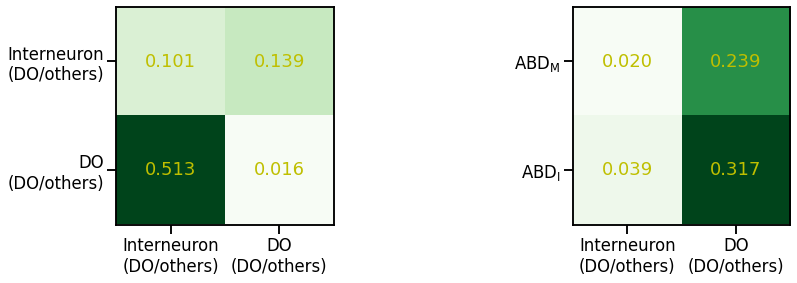

In [298]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.3f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

### 8. Completing the Diagram

In [307]:
def validate_syn_prob_MI_multi_do_oth(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

    # merge sink-non-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['celltype'].a == 15))]
    abdi_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdi_fv:
            merge_g.merge_vertices(v, abdi_fv)
        
    # merge sink-abd neurons
    mclass = m.get_vertices()[gen_mask((m.vp['celltype'].a == 14))]
    abdm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != abdm_fv:
            merge_g.merge_vertices(v, abdm_fv)
            
    # merge blockO1 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_sg_4sbm_DO'].a == 0))]
    O1_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O1_fv:
            merge_g.merge_vertices(v, O1_fv)
            
    # merge blockO2 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_sg_4sbm_DO'].a == 1))]
    O2_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O2_fv:
            merge_g.merge_vertices(v, O2_fv)
            
    # merge blockO3 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_sg_4sbm_DO'].a == 3))]
    O3_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O3_fv:
            merge_g.merge_vertices(v, O3_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat([abdm_fv,abdi_fv,O1_fv,O2_fv,O3_fv], len(bids)),
                        np.tile(center_fvs, 5)].reshape(5, len(bids))
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [321]:
def validate_syn_prob_input_multi_do_oth(g, sbm_name, weight='#synapses', bids=[0,1], norm=True):
    m = g.copy()

    ew = m.new_edge_property("int32_t")
    for e in m.edges():
        if weight:
            ew[e] = m.ep[weight][e]
        else:
            ew[e] = 1

    merge_g = gt.BlockState(m, B=len(m.get_vertices()), eweight=ew)

#     # merge sink neurons
#     mclass = m.get_vertices()[gen_mask(m.vp['peripheral'].a == 1)]
#     fv = mclass[0]
#     # print("source", fv)
#     for i, v in enumerate(m.vertices()):
#         if v in mclass and v != fv:
#             merge_g.merge_vertices(v, fv)

    # merge souce saccadic M neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 0))]
    sacm_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != sacm_fv:
            merge_g.merge_vertices(v, sacm_fv)
        
    # merge souce saccadic I neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 1))]
    saci_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != saci_fv:
            merge_g.merge_vertices(v, saci_fv)
            
    # merge souce IBN neurons
    mclass = m.get_vertices()[gen_mask(
                                       (m.vp['celltype'].a == 3))]
    ibn_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != ibn_fv:
            merge_g.merge_vertices(v, ibn_fv)
            
    # merge blockO1 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_sg_4sbm_DO'].a == 0))]
    O1_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O1_fv:
            merge_g.merge_vertices(v, O1_fv)
            
    # merge blockO2 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_sg_4sbm_DO'].a == 1))]
    O2_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O2_fv:
            merge_g.merge_vertices(v, O2_fv)
            
    # merge blockO3 neurons
    mclass = m.get_vertices()[gen_mask((m.vp['modO_sg_4sbm_DO'].a == 3))]
    O3_fv = mclass[0]
    for i, v in enumerate(m.vertices()):
        if v in mclass and v != O3_fv:
            merge_g.merge_vertices(v, O3_fv)
    
    center_fvs = []
    for bid in bids:
        mclass = m.get_vertices()[gen_mask(m.vp[sbm_name].a == bid)]
        center_fvs.append(mclass[0])
        for i, v in enumerate(m.vertices()):
            if v in mclass and v != center_fvs[-1]:
                merge_g.merge_vertices(v, center_fvs[-1])

    mg = merge_g.get_bg()
    mg.ep["ers"] = merge_g.get_ers()
    mg.vp["nr"] = merge_g.get_nr()

    p_syn = mg.new_edge_property("float")
    for e in mg.edges():
        if norm:
            p_syn[e] = mg.ep["ers"][e] / (mg.vp["nr"][e.target()] * mg.vp["nr"][e.source()])
        else:
            p_syn[e] = mg.ep["ers"][e]
    mg.ep["p_syn"] = p_syn

    A_mg = gt.adjacency(mg, weight=mg.ep["p_syn"]).todense()

    syn_prob_abd = A_mg[np.repeat(center_fvs, 6),
                        np.tile([sacm_fv, saci_fv, ibn_fv, 
                                 O1_fv, O2_fv, O3_fv], len(bids))].reshape(len(bids), 6)
    
    syn_prob_block = A_mg[np.repeat(center_fvs, len(bids)), 
                          np.tile(center_fvs, len(bids))
                         ].reshape(len(bids), len(bids))

    return syn_prob_abd, syn_prob_block

In [303]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "modO_{}_4sbm".format(k), bids=[2,0,1,3], weight='#synapses', norm=False)

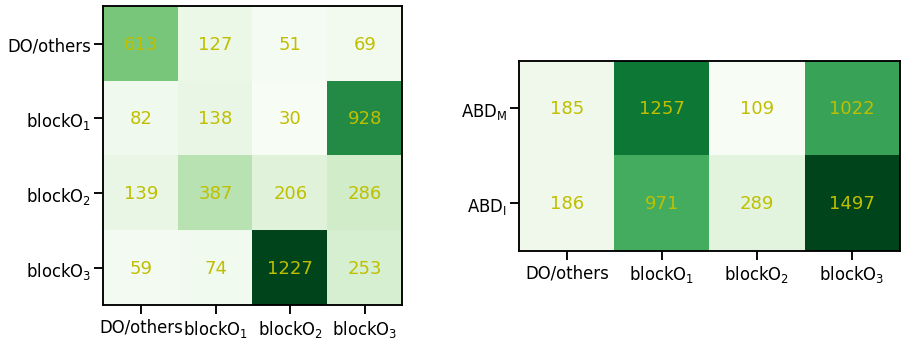

In [306]:
fig, axs = plt.subplots(1,2, figsize=(15,5.5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [310]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi_do_oth(g, "modO_{}_4sbm_DO".format(k),  weight='#synapses', bids=[2,4], norm=False)

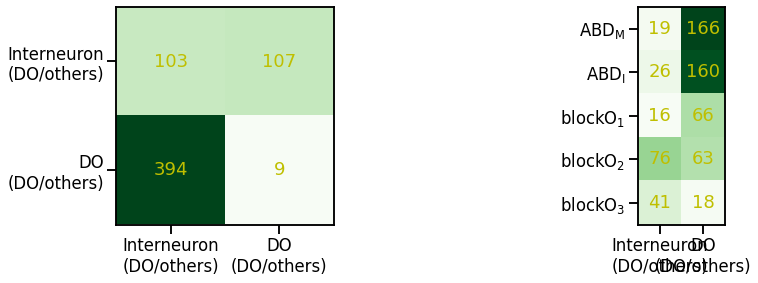

In [317]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(5):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(5))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [319]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_4sbm".format(k), bids=[2,0,1,3], weight='#synapses', norm=False)

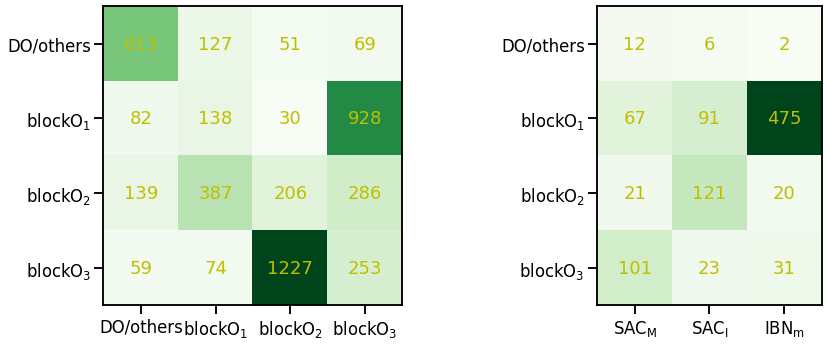

In [320]:
fig, axs = plt.subplots(1,2, figsize=(15,5.5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(4):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [328]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi_do_oth(g, "modO_{}_4sbm_DO".format(k), bids=[2,4], weight='#synapses', norm=False)

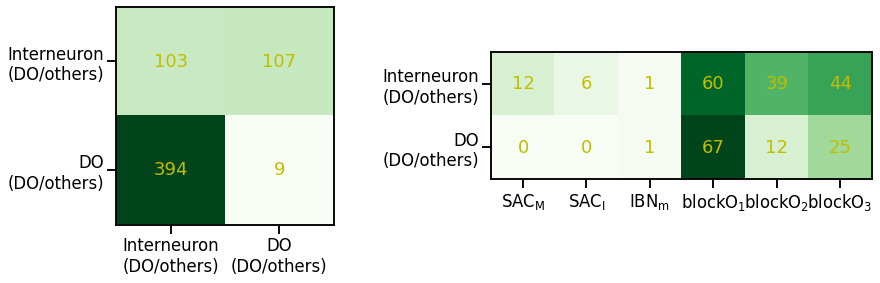

In [329]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Greens")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Greens")
        for i in range(2):
            for j in range(6):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(6))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])

plt.show()

In [330]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi(g, "modO_{}_4sbm".format(k), bids=[2,0,1,3], weight=None, norm=False)

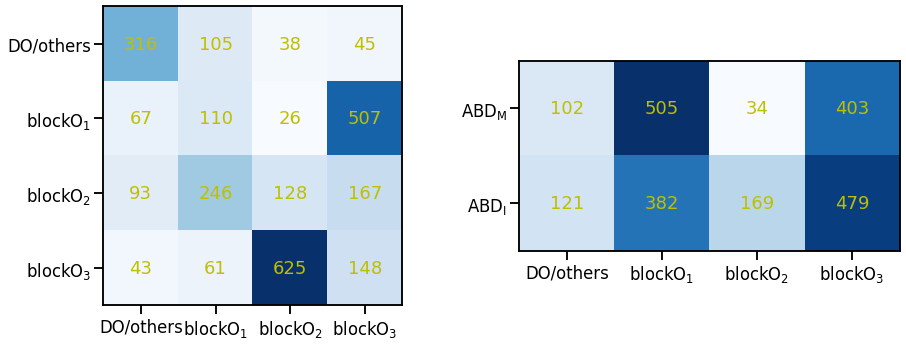

In [331]:
fig, axs = plt.subplots(1,2, figsize=(15,5.5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(2):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$"])

plt.show()

In [333]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_MI_multi_do_oth(g, "modO_{}_4sbm_DO".format(k),  weight=None, bids=[2,4], norm=False)

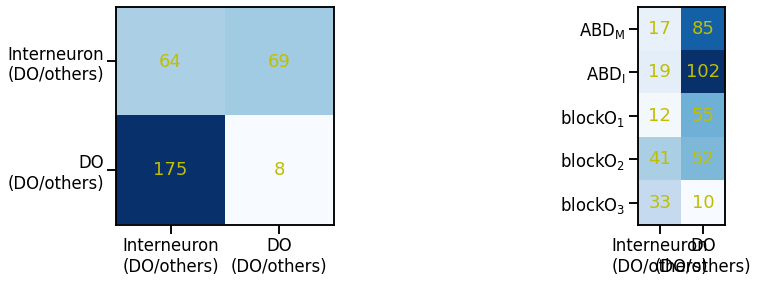

In [336]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(5):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(5))
        ax.set_yticklabels(["$ABD_M$", "$ABD_I$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [337]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi(g, "modO_{}_4sbm".format(k), bids=[2,0,1,3], weight=None, norm=False)

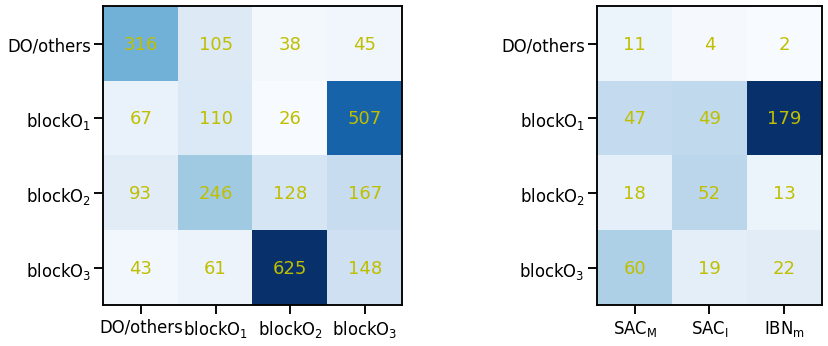

In [338]:
fig, axs = plt.subplots(1,2, figsize=(15,5.5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(4):
            for j in range(4):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(4):
            for j in range(3):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$"])
        ax.set_yticks(range(4))
        ax.set_yticklabels(["DO/others", "$blockO_1$", "$blockO_2$", "$blockO_3$"])

plt.show()

In [340]:
syn_prob_abd, syn_prob_block = {}, {}
names = ['sg']
for k in names:
    syn_prob_abd[k], syn_prob_block[k] = validate_syn_prob_input_multi_do_oth(g, "modO_{}_4sbm_DO".format(k), bids=[2,4], weight=None, norm=False)

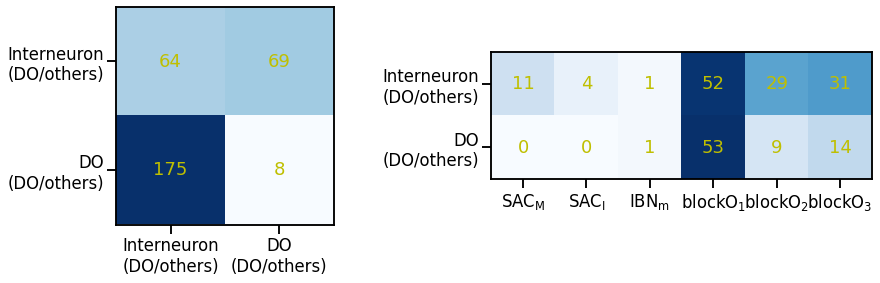

In [341]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
for l, ax in enumerate(axs):
    if l < 1:
        ax.imshow(syn_prob_block['sg'], cmap="Blues")
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_block['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(2))
        ax.set_xticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])
        
    else:
        ax.imshow(syn_prob_abd['sg'], cmap="Blues")
        for i in range(2):
            for j in range(6):
                text = ax.text(j, i, "{:.0f}".format(syn_prob_abd['sg'][i, j]),
                               ha="center", va="center", color="y")
        ax.set_xticks(range(6))
        ax.set_xticklabels(["$SAC_M$", "$SAC_I$", "$IBN_m$", "$blockO_1$", "$blockO_2$", "$blockO_3$"])
        ax.set_yticks(range(2))
        ax.set_yticklabels(["Interneuron\n(DO/others)", "DO\n(DO/others)"])

plt.show()

### 9. Sanky Diagram

In [48]:
import plotly.graph_objects as go
from IPython.core.display import display
from IPython.display import IFrame

In [49]:
# calculate source, target, values
def get_stv(source_labels, target_labels):
    s, t, v = [], [], []
    links, values = np.unique(list(zip(source_labels, target_labels)), 
                      axis=0, return_counts=True)
    for i in range(len(links)):
        s.append(links[i][0])
        t.append(links[i][1])
        v.append(values[i])
        
    return s, t, v

In [50]:
sbms = [0, modO.vp["modO_sg_sbm"], modO.vp["modO_sg_3sbm"], modO.vp["modO_sg_4sbm"]]
total_num_block = 0
source, target, value = [], [], []
label = ["modO", " ", " ", "blockO1", "blockO2", "blockO3", "blockO1", "blockO2", "DO/others", "blockO3"]
for i in range(3):
    if i > 0:
        stmp, ttmp, vtmp = get_stv(sbms[i].a + total_num_block, 
                               sbms[i+1].a + total_num_block + i + 1)
    else:
        stmp, ttmp, vtmp = get_stv(np.zeros(len(list(modO.vertices()))) + total_num_block, 
                               sbms[i+1].a + total_num_block + i + 1)
    total_num_block = total_num_block + i + 1
    source = source + stmp
    target = target + ttmp
    value = value + vtmp

In [51]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)

In [52]:
fig = go.Figure(data)
fig.write_html('figures/sankey-sbm-modO.html')
display(IFrame('figures/sankey-sbm-modO.html', width=900, height=600))

### 10. Paticipation to cycles of each neuron

In [77]:
new_g = gt.load_graph("saved/whole-w-all-abd.xml.gz")

In [81]:
toABD_cid = []
for v in new_g.vertices():
    if new_g.vp["celltype"][v] in [14,15]:
        for e in new_g.get_in_edges(v):
            toABD_cid.append(new_g.vp["cellid"][e[0]])
    
toABD_cid = np.unique(toABD_cid)

In [192]:
# count number of 3-cycle in (1,2,3)
group_partition = [[-1,1,2]]

allcycle_cnt = {str(grp): 0 for grp in group_partition}

cellid_3ptp_3sbm = {modO.vp["cellid"][v]:0 for v in modO.vertices()}
cellid_3ptp_3sbm_collector = []

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["blockO1_DO"][e1.source()] == grp[0]) and\
           (modO.vp["blockO1_DO"][e1.target()] == grp[1]) and\
           (not e1.source() in modO.get_out_neighbors(e1.target())):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["blockO1_DO"][e2[0]] == grp[1]) and\
                   (modO.vp["blockO1_DO"][e2[1]] == grp[2]) and\
                   (not e2[0] in modO.get_out_neighbors(e2[1])):

                    for e3 in modO.get_out_edges(e2[1]):
                        if (modO.vp["blockO1_DO"][e3[0]] == grp[2]) and\
                           (e1.source() == e3[1]) and\
                           (not e3[0] in modO.get_out_neighbors(e3[1])):

                            cellid_3ptp_3sbm[modO.vp["cellid"][e1.source()]] += 1
                            cellid_3ptp_3sbm[modO.vp["cellid"][e1.target()]] += 1
                            cellid_3ptp_3sbm[modO.vp["cellid"][e2[1]]] += 1
                            cellid_3ptp_3sbm_collector.append((int(e1.source()), int(e1.target()), e2[1]))

In [193]:
block_id = 0
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(0, 56) (49, 7) (0, 0) (49, 7)


In [194]:
block_id = 1
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(9, 61) (35, 35) (3, 6) (32, 29)


In [195]:
block_id = 2
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(7, 66) (54, 19) (2, 5) (52, 14)


In [196]:
block_id = -1
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(13, 11) (23, 1) (12, 1) (11, 0)


In [197]:
np.unique(np.array(cellid_3ptp_3sbm_collector)[:,1:])

array([  3,  27,  32,  63,  85,  97,  98, 102, 106, 109, 125, 126, 130,
       131, 163, 219])

In [159]:
np.unique(np.array(cellid_3ptp_3sbm_collector)[:,1:])

array([  3,  27,  32,  63,  85,  97,  98, 102, 106, 109, 125, 126, 130,
       131, 163, 219])

In [200]:
novel_nid = [i for i in [  3,  27,  32,  63,  85,  97,  98, 102, 106, 109, 125, 126, 130,
       131, 163, 219] if i not in [  4,   7,   9,  20,  23,  24,  28,  31,  33,  34,  37,  43,  44,
        45,  49,  50,  56,  57,  58,  59,  61,  62,  63,  79,  84,  85,
        87,  88,  95, 106, 107, 110, 111, 112, 113, 114, 116, 117, 118,
       119, 122, 123, 124, 125, 126, 130, 131, 138, 139, 140, 142, 158,
       162, 163, 171, 178, 179, 180, 184, 185, 186, 189, 190, 197, 207,
       215, 218]]

In [204]:
[modO_nid2cid[i] for i in vsO[1] if i in novel_nid]

[77127, 78356, 81870]

In [205]:
[modO_nid2cid[i] for i in vsO[2] if i in novel_nid]

[76469, 77152, 78226, 78241, 78256]

In [204]:
# count number of 3-cycle in (1,2,3)
group_partition = [[-1,0,1],[-1,1,2],[0,1,2]]

cellid_3ptp_3sbm = {modO.vp["cellid"][v]:0 for v in modO.vertices()}
cellid_3ptp_3sbm_collector = []

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["blockO1_DO"][e1.source()] == grp[0]) and\
           (modO.vp["blockO1_DO"][e1.target()] == grp[1]) and\
           (not e1.source() in modO.get_out_neighbors(e1.target())):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["blockO1_DO"][e2[0]] == grp[1]) and\
                   (modO.vp["blockO1_DO"][e2[1]] == grp[2]) and\
                   (not e2[0] in modO.get_out_neighbors(e2[1])):

                    for e3 in modO.get_out_edges(e2[1]):
                        if (modO.vp["blockO1_DO"][e3[0]] == grp[2]) and\
                           (e1.source() == e3[1]) and\
                           (not e3[0] in modO.get_out_neighbors(e3[1])):

                            cellid_3ptp_3sbm[modO.vp["cellid"][e1.source()]] += 1
                            cellid_3ptp_3sbm[modO.vp["cellid"][e1.target()]] += 1
                            cellid_3ptp_3sbm[modO.vp["cellid"][e2[1]]] += 1
                            cellid_3ptp_3sbm_collector.append((int(e1.source()), int(e1.target()), e2[1]))

In [205]:
block_id = -1
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(15, 9)

In [46]:
block_id = 0
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(33, 23)

In [47]:
block_id = 1
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(26, 44)

In [48]:
block_id = 2
ptp = np.array([cellid_3ptp_3sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["blockO1_DO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(49, 24)

In [49]:
# count number of 3-cycle in (1,2,3)
group_partition = [[0,1,2]]

cellid_3ptp_3sbm_nonDO = {modO_IN.vp["cellid"][v]:0 for v in modO_IN.vertices()}

for grp in group_partition:

    for e1 in modO_IN.edges():
        if (modO_IN.vp["modO_sg_3sbm_nonDO"][e1.source()] == grp[0]) and\
           (modO_IN.vp["modO_sg_3sbm_nonDO"][e1.target()] == grp[1]) and\
           (not e1.source() in modO_IN.get_out_neighbors(e1.target())):

            for e2 in modO_IN.get_out_edges(e1.target()):
                if (modO_IN.vp["modO_sg_3sbm_nonDO"][e2[0]] == grp[1]) and\
                   (modO_IN.vp["modO_sg_3sbm_nonDO"][e2[1]] == grp[2]) and\
                   (not e2[0] in modO_IN.get_out_neighbors(e2[1])):

                    for e3 in modO_IN.get_out_edges(e2[1]):
                        if (modO_IN.vp["modO_sg_3sbm_nonDO"][e3[0]] == grp[2]) and\
                           (e1.source() == e3[1]) and\
                           (not e3[0] in modO_IN.get_out_neighbors(e3[1])):

                            cellid_3ptp_3sbm_nonDO[modO_IN.vp["cellid"][e1.source()]] += 1
                            cellid_3ptp_3sbm_nonDO[modO_IN.vp["cellid"][e1.target()]] += 1
                            cellid_3ptp_3sbm_nonDO[modO_IN.vp["cellid"][e2[1]]] += 1

In [50]:
block_id = 0
ptp = np.array([cellid_3ptp_3sbm_nonDO[modO_IN.vp["cellid"][v]] 
             for v in modO_IN.vertices() 
             if modO_IN.vp["modO_sg_3sbm_nonDO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(34, 14)

In [52]:
block_id = 1
ptp = np.array([cellid_3ptp_3sbm_nonDO[modO_IN.vp["cellid"][v]] 
             for v in modO_IN.vertices() 
             if modO_IN.vp["modO_sg_3sbm_nonDO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(24, 59)

In [53]:
block_id = 2
ptp = np.array([cellid_3ptp_3sbm_nonDO[modO_IN.vp["cellid"][v]] 
             for v in modO_IN.vertices() 
             if modO_IN.vp["modO_sg_3sbm_nonDO"][v] == block_id])
np.sum(ptp > 0), np.sum(ptp == 0)

(47, 19)

In [109]:
# count number of 3-cycle in (1,2,3)
group_partition = [[0,1,3]]

cellid_3ptp_4sbm = {modO.vp["cellid"][v]:0 for v in modO.vertices()}

for grp in group_partition:

    for e1 in modO.edges():
        if (modO.vp["modO_sg_4sbm_DO"][e1.source()] == grp[0]) and\
           (modO.vp["modO_sg_4sbm_DO"][e1.target()] == grp[1]) and\
           (not e1.source() in modO.get_out_neighbors(e1.target())):

            for e2 in modO.get_out_edges(e1.target()):
                if (modO.vp["modO_sg_4sbm_DO"][e2[0]] == grp[1]) and\
                   (modO.vp["modO_sg_4sbm_DO"][e2[1]] == grp[2]) and\
                   (not e2[0] in modO.get_out_neighbors(e2[1])):

                    for e3 in modO.get_out_edges(e2[1]):
                        if (modO.vp["modO_sg_4sbm_DO"][e3[0]] == grp[2]) and\
                           (e1.source() == e3[1]) and\
                           (not e3[0] in modO.get_out_neighbors(e3[1])):

                            cellid_3ptp_4sbm[modO.vp["cellid"][e1.source()]] += 1
                            cellid_3ptp_4sbm[modO.vp["cellid"][e1.target()]] += 1
                            cellid_3ptp_4sbm[modO.vp["cellid"][e2[1]]] += 1

In [110]:
block_id = 0
ptp = np.array([cellid_3ptp_4sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(31, 17) (47, 1) (31, 0) (16, 1)


In [111]:
block_id = 1
ptp = np.array([cellid_3ptp_4sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(22, 33) (32, 23) (15, 7) (17, 16)


In [112]:
block_id = 3
ptp = np.array([cellid_3ptp_4sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)

(45, 19) (55, 9) (45, 0) (10, 9)


In [102]:
block_id = 2
ptp = np.array([cellid_3ptp_4sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)
np.sum(ptp > 0), np.sum(ptp == 0)

(0, 32) (6, 26) (0, 0) (6, 26)


(0, 32)

In [107]:
block_id = 4
ptp = np.array([cellid_3ptp_4sbm[modO.vp["cellid"][v]] 
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])
toABD = np.array([modO.vp["cellid"][v] in toABD_cid
             for v in modO.vertices() 
             if modO.vp["modO_sg_4sbm_DO"][v] == block_id])

print(
    (np.sum(ptp > 0), np.sum(ptp == 0)),
    (np.sum(toABD), np.sum(~toABD)),
    (np.sum((ptp>0) & toABD), np.sum((ptp>0) & ~toABD)),
    (np.sum((ptp==0) & toABD), np.sum((ptp==0) & ~toABD))
)
np.sum(ptp > 0), np.sum(ptp == 0)

(0, 24) (21, 3) (0, 0) (21, 3)


(0, 24)

In [132]:
82878 in modO.vp["cellid"].a

False

In [141]:
# are the excitatory DOs in the center?
cids = [82163,
81348,
81373,
81351,
82878]

for c in cids:
    print(c in g.vp["cellid"].a[gen_mask(g.vp["center"].a)])

False
False
False
False
False


### 11. Visualize block cycles 

In [180]:
def vis_link(segs, colors=None, mode='single'):
    if mode == 'single':
        with open("./saved/ng_template/single-view.txt") as f:
            ng_tmp = f.read()
        return ng_tmp.format("%22%2C%22".join([str(seg) for seg in segs]))
    elif mode == "color":
        with open("./saved/ng_template/colored-single-view.txt") as f:
            ng_tmp = f.read()
        seg, seg_color = segs, colors
        color_string = "%22%2C%22".join(["{}%22:%22{}".format(se, co) for se, co in zip(seg, seg_color)])
        seg_string = "%22%2C%22".join([str(se) for se in seg])
        return ng_tmp.format(color_string, seg_string)
    return None

In [181]:
modO_nid2cid = {int(v):modO.vp["cellid"][v] for v in modO.vertices()}

In [182]:
vis_link([modO_nid2cid[i] for i in cellid_3ptp_3sbm_collector[0]], colors=["#ff0000", "#00ff00", "#0000ff"], mode="color")

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/qaffinitymap-x%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22qaffinitymap-x%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/segmentation2%22%2C%22type%22:%22segmentation%22%2C%22notSelectedAlpha%22:0.41%2C%22objectAlpha%22:0.62%2C%22segments%22:%5B%2212760%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22segmentation2%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/image%22%2C%22type%22:%22image%22%2C%22opacity%22:0.43%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22image%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/consensus-20190923%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha

In [229]:
# vis_link([modO_nid2cid[i] for i in np.unique(cellid_3ptp_3sbm_collector)])

In [161]:
len(np.unique(cellid_3ptp_3sbm_collector))

29

In [162]:
vsO = [np.unique([c[b] for c in cellid_3ptp_3sbm_collector]).tolist() for b in range(3)]
[len(vsO[b]) for b in range(3)]

[13, 9, 7]

In [185]:
ordered_3ptp_list = vsO[0] + vsO[1] + vsO[2]
ordered_3ptp_color_list = ["#ff0000"]*len(vsO[0]) + ["#00ff00"]*len(vsO[1]) + ["#0000ff"]*len(vsO[2])
# ordered_3ptp_list = vsO[0] + vsO[1]
# ordered_3ptp_color_list = ["#ff0000"]*len(vsO[0]) + ["#00ff00"]*len(vsO[1])
# ordered_3ptp_list = vsO[1] + vsO[2]
# ordered_3ptp_color_list = ["#00ff00"]*len(vsO[1]) + ["#0000ff"]*len(vsO[2])
# ordered_3ptp_list = vsO[2] + vsO[0]
# ordered_3ptp_color_list = ["#0000ff"]*len(vsO[2]) + ["#ff0000"]*len(vsO[0])

In [186]:
vis_link([modO_nid2cid[i] for i in ordered_3ptp_list], colors=ordered_3ptp_color_list, mode="color")

'https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/qaffinitymap-x%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22qaffinitymap-x%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/segmentation2%22%2C%22type%22:%22segmentation%22%2C%22notSelectedAlpha%22:0.41%2C%22objectAlpha%22:0.62%2C%22segments%22:%5B%2212760%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22name%22:%22segmentation2%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/image%22%2C%22type%22:%22image%22%2C%22opacity%22:0.43%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22image%22%2C%22visible%22:false%7D%2C%7B%22source%22:%22precomputed://gs://neuroglancer/zfish_v1/consensus-20190923%22%2C%22type%22:%22segmentation%22%2C%22selectedAlpha

In [ ]:
vis_link(([modO_nid2cid[i] for i in ordered_3ptp_list], ordered_3ptp_color_list), mode="color")